<font color='blue'> **Zahasky_08_________________a_________________** </font> 

In [1]:
import flopy; import sys; import pathlib; import os; import time; import numpy as np; import matplotlib.pyplot as plt ; from pathlib import Path ; import pandas as pd
EXF='E:\\15_REPOS\\00_BETAMI\\bin\\MF2005.exe'   ; EXT='E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64.exe'  ; _R=Path("_R"); _R.mkdir(exist_ok=True)          
TA=Path("_R/_08a"); TA.mkdir(exist_ok=True)       ; REF1= ('E:/15_REPOS/02_Beta-Me/data/Madison')    ; D1=os.path.join(REF1,'A_sig100.csv')  ; D2 = os.path.join(REF1,'A_sig100000.csv')

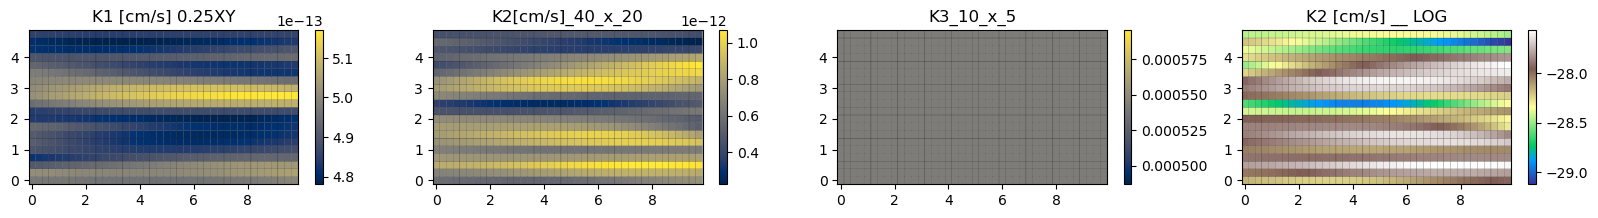

In [2]:
MO_=np.loadtxt(D1,delimiter=',')   ;R=int(MO_[-2]);C=int(MO_[-1]) ;MO_=MO_[0:-2]   ;MO1=MO_.reshape(1,R,C) ;HK1=MO1*(1000*9.81*100/8.9E-4)   ;   
MO_=np.loadtxt(D2,delimiter=',')   ;R=int(MO_[-2]);C=int(MO_[-1]) ;MO_=MO_[0:-2]   ;MO2=MO_.reshape(1,R,C) ;HK2=MO2*(1000*9.81*100/8.9E-4)   ; nrow=R ; ncol=C  

II=np.exp(np.sum(np.log(HK1))/HK1.size)  ; HK0 = II*np.ones([1, 20, 40])           ;MO22=np.log(MO2[0,:,:])
LGRID=[0.25,0.25] ; Lx=(ncol-1)*LGRID[1] ;Ly=(nrow-1)*LGRID[0]                     ;y,x = np.mgrid[slice(0,Ly+LGRID[0],LGRID[0])   ,slice(0,Lx+LGRID[1],LGRID[1])]

fig = plt.figure(figsize=(20, 2), dpi=100)                                         
ax=fig.add_subplot(141) ; plt.pcolor(x,y,MO1[0,:,:],cmap='cividis',shading='auto',edgecolor='k',linewidth=0.1)  ;plt.colorbar() ;plt.title('K1 [cm/s] 0.25XY')
ax=fig.add_subplot(142) ; plt.pcolor(x,y,MO2[0,:,:],cmap='cividis',shading='auto',edgecolor='k',linewidth=0.1)  ;plt.colorbar() ;plt.title('K2[cm/s]_'+ '%1.0f' %(ncol) +'_x_'+'%1.0f' %(nrow))

ax=fig.add_subplot(143) ; plt.pcolor(x,y,HK0[0,:,:],cmap='cividis',shading='auto',edgecolor='k',linewidth=0.1)  ;plt.colorbar() ;plt.title('K3_'+ '%1.0f' %(Lx) +'_x_'+'%1.0f' %(Ly)) 
ax=fig.add_subplot(144) ; plt.pcolor(x,y,MO22      ,cmap='terrain',shading='auto',edgecolor='k',linewidth=0.1)  ;plt.colorbar() ;plt.title('K2 [cm/s] __ LOG') ; plt.show()

In [3]:
delv = 0.25  ;delr = 0.25 ;delc = 1  ; VV = 0.01 ;  TRPT =0.1 ; itype= -1 ; DISP = 0.01; DISP = 0.2                                       ; itmuni=1; lenuni=3 ;MTU='S';MTV='CM'
PERLEN_T = [60*3,60*58]        ; NPER_T = len(PERLEN_T)   ; NPRS = 100
PERLEN_F = [np.sum(PERLEN_T)]  ; NPER_F = len(PERLEN_F)   ; TIMPRS=np.linspace(0,np.sum(PERLEN_F), NPRS, endpoint = False)  ; print('PERLEN_T :',PERLEN_T, 'PERLEN_F :',PERLEN_F)

PERLEN_T : [180, 3480] PERLEN_F : [3660]


In [4]:
def model_2D(DIR, PERLEN_T, HK, VV, DISP, TRPT, itype):
    
    HK_size = HK.shape ;nlay=HK_size[0] ;nrow=HK_size[1] ; ncol=HK_size[2]         ; IB = np.ones((nlay, nrow, ncol) , dtype=int)        ; IB[0,:,0]=-1 ;IB[0,:,-1] = -1      
    K_MEAN=np.exp(np.sum(np.log(HK))/HK.size) ;RO=0.3 ;q=VV*RO ;Lx=(ncol-1)*delr   ; IC = np.zeros((nlay,nrow,ncol),dtype=float)         ; H1   = q*Lx/K_MEAN  ;IC[0,:,0]= H1
    IBC = np.ones((nlay, nrow, ncol) , dtype=int)                                  ; SCONC = np.zeros((nlay, nrow, ncol), dtype=float)   ; C_IN = [1.0, 0.0] 
    
    CW1 = np.zeros((nrow, 5), dtype=float)
    for row in range(0, nrow):   CW1[row] = [0, row, 0, C_IN[0], itype]                           
    CW2 = CW1.copy()            ;CW2[:,3] =             C_IN[1]                    ; MTW_S = {0:CW1, 1:CW2}        ; MF=DIR+'_mf';MT=DIR+'_mt'  ;WS=os.path.join(TA,DIR)
    
    mf  = flopy.modflow.Modflow (modelname=MF, model_ws=WS, exe_name=EXF)
    dis = flopy.modflow.ModflowDis (mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=NPER_F, delr=delr, delc=delc, top=0., botm=[0 - delv],perlen=PERLEN_F, itmuni=itmuni, lenuni=lenuni)
    bas = flopy.modflow.ModflowBas (mf, ibound=IB, strt=IC)  ; lpf = flopy.modflow.ModflowLpf(mf, hk=HK, laytyp=0)
    pcg = flopy.modflow.ModflowPcg (mf) ;lmt = flopy.modflow.ModflowLmt(mf) ; oc = flopy.modflow.ModflowOc(mf)                               ;mf.write_input() ;mf.run_model(silent=True) 

    mt  = flopy.mt3d.Mt3dms  (modelname=MT, model_ws=WS, exe_name=EXT, modflowmodel=mf)            ;mixelm = -1 ;adv=flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    btn = flopy.mt3d.Mt3dBtn (mt, icbund=IBC, prsity=RO, sconc=SCONC, tunit=MTU, lunit=MTV, nper=NPER_T, perlen=PERLEN_T, nprs=NPRS, timprs=TIMPRS ) 
    dsp = flopy.mt3d.Mt3dDsp (mt, al=DISP, trpt=TRPT)    ;ssm=flopy.mt3d.Mt3dSsm(mt,stress_period_data=MTW_S)   ;gcg=flopy.mt3d.Mt3dGcg(mt)  ;mt.write_input() ;mt.run_model(silent=True)

    if os.path.isfile(os.path.join(WS, 'MT3D001.UCN')):  os.remove(os.path.join(WS, 'MT3D001.UCN'))  
    mt.run_model(silent=True)
    
    hdobj  = flopy.utils.HeadFile(os.path.join(WS, MF+'.hds'))       ; heads = hdobj.get_data()               ; print("Inlet_H:"+str(H1) + "('Cm')") 
    ucnobj = flopy.utils.UcnFile(os.path.join(WS, 'MT3D001.UCN'))    ; times = np.array(ucnobj.get_times())   ; CON0 = ucnobj.get_alldata()   ; return mf, mt, times, CON0, heads

In [5]:
DIR='ANI0'  ; mf,mt,times,CON0,heads = model_2D(DIR, PERLEN_T, HK0, VV, DISP, TRPT, itype) 
DIR='ANI1'  ; mf,mt,times,CON1,heads = model_2D(DIR, PERLEN_T, HK1, VV, DISP, TRPT, itype) ; DIR = 'ANI2'  ; mf,mt,times,CON2,heads = model_2D(DIR, PERLEN_T, HK2, VV, DISP, TRPT, itype)

C0_MEAN = np.transpose(np.mean([CON0[:,0,:,-1]],axis=2))   ;C1_MEAN=np.transpose(np.mean([CON1[:,0,:,-1]],axis=2))              ;C2_MEAN = np.transpose(np.mean([CON2[:,0,:,-1]],axis=2)) 

Inlet_H:54.04438360720681('Cm')
Inlet_H:54.04438360720681('Cm')
Inlet_H:40.687843609043746('Cm')


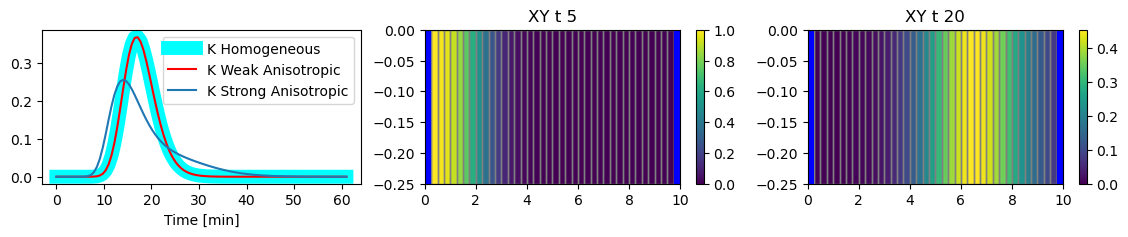

In [6]:
WIN1 = 5 ; WIN2 = 20 ; HH= heads
fig = plt.figure(figsize=(14, 2), dpi=100)
ax=fig.add_subplot(131)  
plt.plot(times/60, C0_MEAN, label='K Homogeneous'      , color= 'cyan' , linewidth = 10)
plt.plot(times/60, C1_MEAN, label='K Weak Anisotropic' , color= 'r')
plt.plot(times/60, C2_MEAN, label='K Strong Anisotropic') ; plt.xlabel('Time [min]')   ; plt.legend()    
ax=fig.add_subplot(132);SX=flopy.plot.PlotCrossSection(model=mf,line={'Row':0}) ;VK=SX.plot_array(CON0[WIN1]);SX.plot_grid();plt.colorbar(VK);SX.plot_ibound(head=HH);plt.title('XY t %1.0f'%(WIN1))
ax=fig.add_subplot(133);SX=flopy.plot.PlotCrossSection(model=mf,line={'Row':0}) ;VK=SX.plot_array(CON0[WIN2]);SX.plot_grid();plt.colorbar(VK);SX.plot_ibound(head=HH);plt.title('XY t %1.0f'%(WIN2))

plt.show()

In [7]:
pd.DataFrame(CON0.reshape(CON0.shape[0],-1)).to_csv(TA/"CON0_all[0].csv")  ; pd.DataFrame(CON1.reshape(CON1.shape[0],-1)).to_csv(TA/"CON1_all[0].csv") 
pd.DataFrame(CON2.reshape(CON2.shape[0],-1)).to_csv(TA/"CON2_all[0].csv")

pd.DataFrame(heads[0,:,:]).to_csv (TA/"05_H_steady.csv")   ; pd.DataFrame(CON2 [-1,0,:,:]).to_csv (TA/"06_C16.csv") ; pd.DataFrame(HK2.reshape(nrow, ncol)).to_csv (TA/"01_anis_perm_field_.csv")  
pd.DataFrame(CON2.reshape(CON2.shape[0],-1)).to_csv (TA/"07_C_all_XY.csv") ; pd.DataFrame(times).to_csv (TA/"08_times.csv") ; pd.DataFrame(np.cumsum(PERLEN_T)).to_csv(TA/"09_Times_b.csv")
print(CON1.shape) ; CON1[:,0,:,-1].shape  ; CON0.shape      ; #print(heads.shape)  ; print(CON2.shape) ; pd.DataFrame(CON0[12,0,:,:]).to_csv(TA/'CONC_12.csv') 

(102, 1, 20, 40)
